In [ ]:
# performing the imports we may need to use later in the notebook

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch, os
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/fer2013.csv')
df.head()

emotion                                             pixels     Usage
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...  Training
1        0  151 150 147 155 148 133 111 140 170 174 182 15...  Training
2        2  231 212 156 164 174 138 161 173 182 200 106 38...  Training
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...  Training
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...  Training

In [ ]:
print('Total lenth of dataset: ', len(df.Usage), '\n') # Which is actually also the lenth of total dataframe
print('Total Categories we have: ', df.Usage.unique())
print('Number of data in each category: ', '{ Training: ', len(df[df.Usage == 'Training']), ' PublicTest: ', len(df[df.Usage == 'PublicTest']), ' PrivateTest: ', len(df[df.Usage == 'PrivateTest']), '}\n')
print('Total Expression Classes we have: ', df.emotion.unique(), '\n')
print('Type of the pixel data is: ', type(df.pixels[0]))

Total lenth of dataset:  35887 

Total Categories we have:  ['Training' 'PublicTest' 'PrivateTest']
Number of data in each category:  { Training:  28709  PublicTest:  3589  PrivateTest:  3589 }

Total Expression Classes we have:  [0 2 4 6 3 5 1] 

Type of the pixel data is:  <class 'str'>


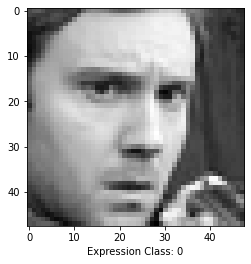

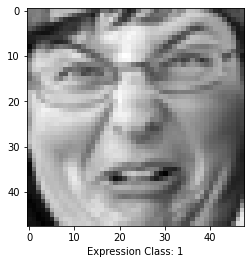

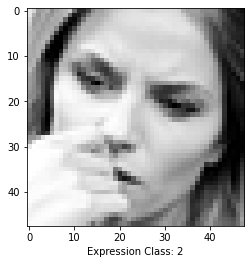

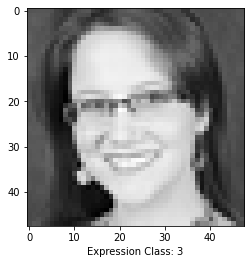

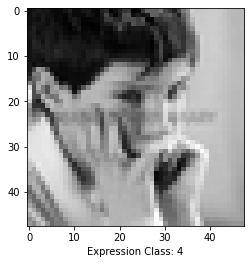

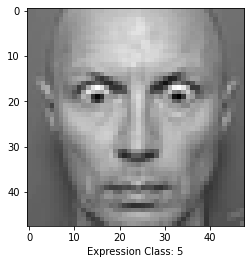

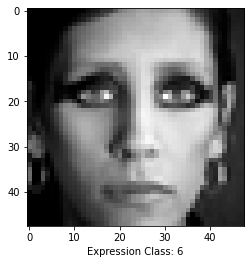

In [ ]:
# since the pixels are in a single long presentation this function will turn it to a matrix of 48x48
def makemtrx(lst, n=48):
    for i in range(0, 48*48, n):  
        yield lst[i:i + n] 

# This function will help to show the images
def showimg(data):
    pixel = [int(i) for i in data[1].split(' ')]
    pixel = np.array(list(makemtrx(pixel)))
    plt.imshow(pixel, cmap='gray')
    plt.xlabel(f'Expression Class: {data[0]}')
    plt.plot()

for i in range(7):
    plt.figure()
    showimg(df[df.emotion == i].values[0])

In [ ]:
classes = {
    0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'
}

In [ ]:
# getting the dataset ready
df_train = pd.concat([df[(df.Usage == 'Training')], df[df.Usage == 'PublicTest']], ignore_index=True).drop(['Usage'], axis=1)
df_test = df[df.Usage == 'PrivateTest'].drop(['Usage'], axis=1).reset_index().drop(['index'], 1)

# differentiating between labels and images
train_images = df_train.iloc[:, 1]
train_labels = df_train.iloc[:, 0]
test_images = df_test.iloc[:, 1]
test_labels = df_test.iloc[:, 0]

In [ ]:
# this is for the transforms
train_trfm = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.Grayscale(num_output_channels=1),
        transforms.RandomCrop(48, padding=4, padding_mode='reflect'),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5), inplace=True)
    ])
val_trfm = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5))
    ])

In [ ]:
# Creating the class for our dataset for the FER
class FERDataset(Dataset):
    
    def __init__(self, images, labels, transforms):
        self.X = images
        self.y = labels
        self.transforms = transforms
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, i):
        data = [int(m) for m in self.X[i].split(' ')]
        data = np.asarray(data).astype(np.uint8).reshape(48,48,1)
        data = self.transforms(data)
        label = self.y[i]
        return (data, label)
    
# assigning the transformed data
train_data = FERDataset(train_images, train_labels, train_trfm)
val_data = FERDataset(test_images, test_labels, val_trfm)

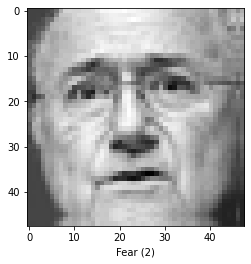

In [ ]:
def showimg(data):
    img, lbl = data
    plt.figure()
    plt.imshow(torch.squeeze(img), cmap='gray')
    plt.xlabel(f'{classes[lbl]} ({lbl})')
    plt.plot()
    
showimg(train_data[5])

In [ ]:
batch_num = 64

train_dl = DataLoader(train_data, batch_num, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_data, batch_num*2, num_workers=2, pin_memory=True)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


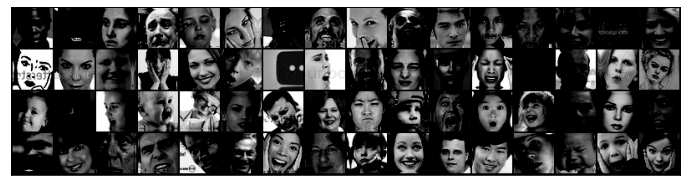

In [ ]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break
        
show_batch(train_dl)

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds==labels).item()/len(preds))

class FERBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))


In [ ]:
def conv_block(in_chnl, out_chnl, pool=False, padding=1):
    layers = [
        nn.Conv2d(in_chnl, out_chnl, kernel_size=3, padding=padding),
        nn.BatchNorm2d(out_chnl),
        nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class FERModelResNet(FERBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.MODEL_NAME = f"model-{int(time.time())}"
        
        self.conv1 = conv_block(in_channels, 64, pool=True) 
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(3),
                                        nn.Flatten(),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        
        return self.classifier(out)


class FERModel(FERBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.MODEL_NAME = f"model-{int(time.time())}"
        
        self.conv1 = conv_block(in_channels, 64, pool=True) 
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(3),
                                        nn.Flatten(),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out)
        
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out)
        
        return self.classifier(out)
        

In [ ]:
def get_output_shape(model, image_dim):
    return model(torch.rand(*(image_dim))).data.shape

class FERModelAlexNet(FERBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.MODEL_NAME = f"model-{int(time.time())}"
        
        self.cnn = nn.Sequential(
            conv_block(in_channels, 64, pool=True),
            conv_block(64, 128, pool=True),
            conv_block(128, 256, pool=True),
            conv_block(256, 512, pool=True)
        )

        conv_out = get_output_shape(self.cnn, (1, 1, 48, 48))
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(np.prod(list(conv_out)), 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )
        
        
    def forward(self, xb):
        x = self.cnn(xb)
        
        return self.classifier(x)


In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
# model = FERModelResNet(1, 7)
# model = FERModelAlexNet(1,7)
model = FERModel(1, 7)
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)

FERModel(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1

In [ ]:
for images, lbl in train_dl:
    print('shape of image: ', images.shape)
    out = model(images)
    print('shape of output: ', out.shape)
    print('Output: ', out[0])
    break

shape of image:  torch.Size([64, 1, 48, 48])
shape of output:  torch.Size([64, 7])
Output:  tensor([ 0.7095,  0.1732, -0.4648, -0.4013,  1.0901,  0.4329, -0.5815],
       device='cuda:0', grad_fn=<SelectBackward>)


In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


def fit(epochs, max_lr, model, train_loader, val_loader, weight_decay=0, grad_clip=None, opt_func=torch.optim.Adam):
    # keeping track of the results
    history = []
    
    # setting upcustom optimizer including weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # setting up 1cycle lr scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))
    
    with open("model.log", 'a') as f:
        for epoch in range(epochs):
            # training
            model.train()
            train_losses = []
            lrs = []
            for batch in train_loader:
                loss = model.training_step(batch)
                train_losses.append(loss)
                loss.backward()
                
                # gradient clipping
                if grad_clip:
                    nn.utils.clip_grad_value_(model.parameters(), grad_clip)
                    
                optimizer.step()
                optimizer.zero_grad()
                
                # record the lr
                lrs.append(get_lr(optimizer))
                sched.step()
                
            # validation
            result = evaluate(model, val_loader)
            result['train_loss'] = torch.stack(train_losses).mean().item()
            result['lrs'] = lrs
            model.epoch_end(epoch, result)
            f.write(f"{model.MODEL_NAME},{round(time.time(),3)},{result['train_loss']},{result['val_acc']},{result['val_loss']},{epoch}\n")
            history.append(result)
    return history

In [ ]:
evaluate(model, val_dl)

{'val_acc': 0.014816810376942158, 'val_loss': 1.9564766883850098}

In [ ]:
max_lr = 0.001
grad_clip = 0.1
weight_decay = 1e-4

In [ ]:
%%time
history = fit(30, max_lr, model, train_loader=train_dl, val_loader=val_dl, weight_decay=weight_decay, grad_clip=grad_clip)

Epoch [0], last_lr: 0.00007, train_loss: 1.5679, val_loss: 1.3920, val_acc: 0.4675
Epoch [1], last_lr: 0.00015, train_loss: 1.3480, val_loss: 1.2535, val_acc: 0.5116
Epoch [2], last_lr: 0.00028, train_loss: 1.2566, val_loss: 1.2359, val_acc: 0.5337
Epoch [3], last_lr: 0.00044, train_loss: 1.2029, val_loss: 1.1970, val_acc: 0.5467


KeyboardInterrupt: ignored

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
    
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');
    
# plot_losses(history)
# plt.figure()
# plot_lrs(history)

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for images, labels in val_dl:
        images, labels = images.to(torch.device('cuda:0')), labels.to(torch.device('cuda:0'))
        out = model(images)
        val, preds = torch.max(out, dim=1)
        correct += torch.sum(preds==labels).item() # item() just takes the value of the 1D tensor
        total += len(preds)
        # print(correct.item(), total)

print("Accuracy: ", round(correct/total, 3))

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import style

style.use("ggplot")

model_name = model.MODEL_NAME


def create_loss_graph(model_name):
    contents = open("model.log", "r").read().split("\n")

    times = []
    accuracies = []
    losses = []

    val_accs = []
    val_losses = []

    for c in contents:
        if model_name in c:
            name, timestamp, loss, val_acc, val_loss, epoch = c.split(",")

            times.append(float(timestamp))
            losses.append(float(loss))

            val_accs.append(float(val_acc))
            val_losses.append(float(val_loss))


    plt.plot(losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')

create_loss_graph(model_name)


In [ ]:
y_label = torch.Tensor([int(x) for x in val_data.y])
y_label

tensor([0., 5., 6.,  ..., 0., 3., 2.])

In [ ]:
@torch.no_grad()
def get_all_preds(model, loader):
    all_preds = torch.tensor([])
    for batch in loader:
        images, labels = batch

        preds = model(images).to(torch.device('cpu'))
        all_preds = torch.cat(
            (all_preds, preds)
            ,dim=0
        )
    return all_preds

with torch.no_grad():
    prediction_loader = DataLoader(val_data, batch_size=400)
    prediction_loader = DeviceDataLoader(prediction_loader, device)
    train_preds = get_all_preds(model1, prediction_loader)

In [ ]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(False)

Normalized confusion matrix
[[0.6191446  0.00610998 0.11201629 0.0203666  0.15071283 0.00814664
  0.08350305]
 [0.16363636 0.70909091 0.03636364 0.01818182 0.05454545 0.
  0.01818182]
 [0.12878788 0.00568182 0.50189394 0.02840909 0.1780303  0.07386364
  0.08333333]
 [0.01934016 0.         0.0182025  0.87827076 0.03071672 0.01478953
  0.03868032]
 [0.1026936  0.003367   0.0959596  0.04040404 0.56565657 0.01178451
  0.18013468]
 [0.01442308 0.00480769 0.10336538 0.03846154 0.01201923 0.81009615
  0.01682692]
 [0.0543131  0.00159744 0.04153355 0.04153355 0.12460064 0.01597444
  0.72044728]]


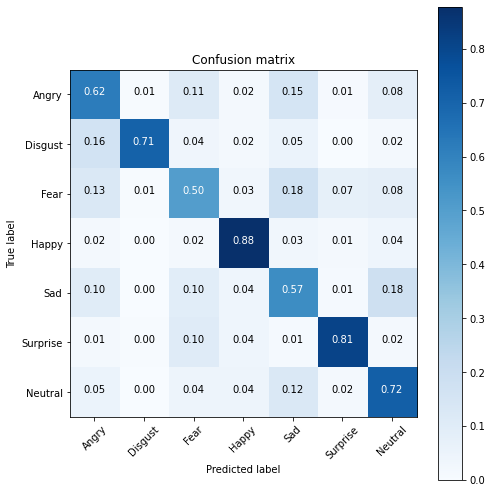

In [ ]:
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_label, train_preds.argmax(dim=1))
plt.figure(figsize=(7,7))
plt.grid(False)
plot_confusion_matrix(cm, classes.values(), True)

In [ ]:
torch.save({
    'model': model3.state_dict(),
    'history': history,
    'cm': cm
}, f"{model3.MODEL_NAME}.pth")

Accuracy:  0.698
Confusion matrix, without normalization
[[304   3  55  10  74   4  41]
 [  9  39   2   1   3   0   1]
 [ 68   3 265  15  94  39  44]
 [ 17   0  16 772  27  13  34]
 [ 61   2  57  24 336   7 107]
 [  6   2  43  16   5 337   7]
 [ 34   1  26  26  78  10 451]]


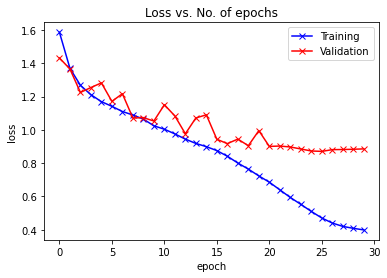

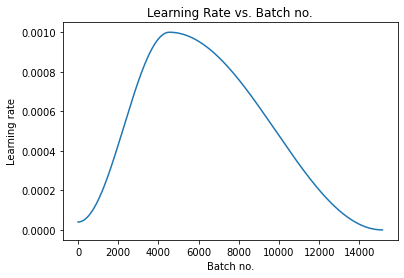

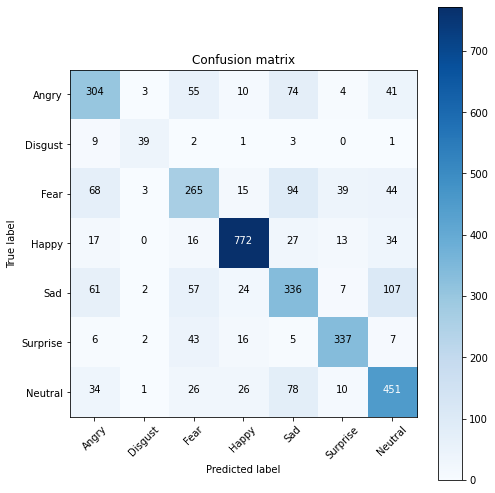

In [ ]:
# history = None
def load_model(model_arch, location):
    model = model_arch(1, 7)
    model_checkpoint = torch.load(location)
    model.to(device)
    model.load_state_dict(model_checkpoint['model'])
    model.eval()
    get_acc(model)
    global history
    history = model_checkpoint['history']
    plt.figure()
    plot_losses(history)
    plt.figure()
    plot_lrs(history)
    plt.figure(figsize=(7,7))
    plot_confusion_matrix(model_checkpoint['cm'], classes.values())
    plt.show()
    return model

def get_acc(model):
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_dl:
            images, labels = images.to(torch.device('cuda:0')), labels.to(torch.device('cuda:0'))
            out = model(images)
            val, preds = torch.max(out, dim=1)
            correct += torch.sum(preds==labels).item() # item() just takes the value of the 1D tensor
            total += len(preds)

    print("Accuracy: ", round(correct/total, 3))

model1 = load_model(FERModelResNet, "/content/drive/MyDrive/Final Year Project files/pytorch models/model-1620066103-resnet.pth")
# model2 = load_model(FERModelAlexNet, "/content/drive/MyDrive/Final Year Project files/pytorch models/model-1620066366-alexnet.pth")
# model3 = load_model(FERModel, "/content/drive/MyDrive/Final Year Project files/pytorch models/model-1620066628-nonresnet.pth")

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, balanced_accuracy_score, classification_report, accuracy_score
# pscore = precision_score(y_label, train_preds.argmax(dim=1), average='weighted')
# print(pscore)
# rscore = recall_score(y_label, train_preds.argmax(dim=1), average='weighted')
# print(rscore)
# fscore = f1_score(y_label, train_preds.argmax(dim=1), average='weighted')
# print(fscore)
bascore = balanced_accuracy_score(y_label, train_preds.argmax(dim=1))
print(bascore)
creport = classification_report(y_label, train_preds.argmax(dim=1), target_names=['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'])
print(creport)
print(accuracy_score(y_label, train_preds.argmax(dim=1)))

0.6863714596305351
              precision    recall  f1-score   support

       Angry       0.61      0.62      0.61       491
     Disgust       0.78      0.71      0.74        55
        Fear       0.57      0.50      0.53       528
       Happy       0.89      0.88      0.89       879
         Sad       0.54      0.57      0.55       594
    Surprise       0.82      0.81      0.82       416
     Neutral       0.66      0.72      0.69       626

    accuracy                           0.70      3589
   macro avg       0.70      0.69      0.69      3589
weighted avg       0.70      0.70      0.70      3589

0.6976873780997492


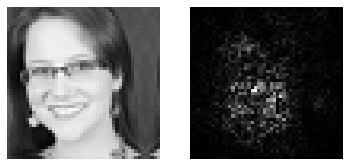

In [ ]:
model.eval()
image, lbl = train_data[7]
image = image.reshape(1, 1, 48, 48)
image = image.to(device)
image.requires_grad_()
output = model(image)
score_max_index = output.argmax()
score_max = output[0,score_max_index]
score_max.backward()
saliency, _ = torch.max(image.grad.data.abs(), dim=1)
saliency = saliency.to("cpu")
fig, ax = plt.subplots(1, 2)
ax[0].imshow(image.cpu().detach().squeeze(), cmap='gray')
ax[0].axis('off')
ax[1].imshow(saliency[0], cmap='gray')
ax[1].axis('off')
plt.show()